<h1 style="background-color: #8EBAD9;
            font-size: 2.5em;
            color: #03112A;
            border-radius: 25px;
            text-align: center;
            padding: 20px;
            font-family: 'Verdana', sans-serif;
            box-shadow: 0px 4px 8px rgba(0, 0, 0, 0.2);">
   <span style="font-weight: bold;"> Task 1: Bayesian Analysis for Arrivals rate using Gaussian Process Regression.</span>
</h1>


<div dir="rtl" style="text-align: right;">
<strong>מגישים : </strong> <br>
 רז אלבז <br>
 נועה ענקי

#### קבוצה : למלא מספר 16

#### Git Link :

<div style="text-align: right;">
    <a href="https://github.com/Razelbaz1/Bayesian_models_project" target="_blank">
        קישור לכל הפרויקט ב - GitHub
    </a>
</div>


##  We wish to evaluate the best six football clubs in the world: Real Madrid, Barcelona, Liverpool, Manchester City, PSG and Inter.

### We wish to support the winning odds of each team in a tournament of the best six teams. What we have is past score from previuos years at which this tournament took place.
  
### We want to infer a latent parameter - that is the 'strength' of a team based only on their **scoring intensity**, and all we have are their scores and results, we can't accurately measure the 'strength' of a team.


In [1]:
# imports
import arviz as az
import pymc as pm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
import pickle as pkl
# from google.colab import drive
# drive.mount('/content/drive')

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install gxx`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.


## The input   looks like as follows:

In [2]:
group = 16
df  = pkl.load(open('group_'+str(group) + '.pkl', 'rb'))
df.head(10)


,home_team,away_team,home_score,away_score,year
0,ManC,Inter,4,3,2014
1,PSG,Real,5,6,2014
2,Barca,Liverpool,5,1,2014
3,Barca,ManC,5,0,2014
4,Liverpool,Real,0,5,2014
5,PSG,Inter,6,2,2014
6,ManC,PSG,5,1,2014
7,Inter,Liverpool,4,5,2014
8,Real,Barca,2,2,2014
9,Barca,Inter,9,1,2014


## We have home and away team, we have score and year.

## What is our goal?

### Our goal is to infer the latent variables—specifically, each team's strength—that give rise to the observed data, namely the scorelines. Since scorelines provide a noisy signal of team strength, we seek a model that allows us to effectively quantify the uncertainty surrounding these underlying strengths.



## Part 1

### We start by conducting an exploratory data analysis to gain an initial understanding of the underlying patterns and structure in the data.

## Tasks



### 1. (4%) Select your favorite team and compare its goal difference in home versus away matches. Is the team performing better at home or away? Visualize this by plotting a bar chart showing the goal difference for both home and away games.

### 2. (4%) Identify the team with the highest 75th percentile performance in away games. For each team, calculate the goal difference for all away matches (goals scored minus goals against) and determine the 75th value. Which team comes out on top?

### 3. (4%) Create a bar chart showing the goal difference for each team (i.e., total goals scored minus total goals against). Based on this plot, which team appears to be the strongest, and which one the weakest?

### 4. (4%) Generate the same bar chart over time for each team. Do any teams exhibit a clear trend, either improving or declining in performance?

<div style="border: 2px solid #8ad3f1; border-radius: 10px; padding: 15px; background-color: #f0f8ff;" dir="rtl">

# שאלה 1

</div>

##### 1. (4%) Select your favorite team and compare its goal difference in home versus away matches. Is the team performing better at home or away? Visualize this by plotting a bar chart showing the goal difference for both home and away games.

In [11]:
# Quick sanity
print("Columns:", list(df.columns))
print("Shape:", df.shape)
print("Teams:", sorted(pd.unique(pd.concat([df["home_team"], df["away_team"]], ignore_index=True)).tolist()))
print("Seasons:", sorted(df["year"].unique().tolist()))

Columns: ['home_team', 'away_team', 'home_score', 'away_score', 'year']
Shape: (60, 5)
Teams: ['Barca', 'Inter', 'Liverpool', 'ManC', 'PSG', 'Real']
Seasons: [2014, 2015, 2016, 2017]


In [12]:
# Build long-form from team perspective (NO column renaming)
home_part = pd.DataFrame({
    "team": df["home_team"],
    "season": df["year"],
    "goals_for": df["home_score"].astype(float),
    "goals_against": df["away_score"].astype(float),
    "venue": "Home",
})
away_part = pd.DataFrame({
    "team": df["away_team"],
    "season": df["year"],
    "goals_for": df["away_score"].astype(float),
    "goals_against": df["home_score"].astype(float),
    "venue": "Away",
})
long = pd.concat([home_part, away_part], ignore_index=True)
long["goal_diff"] = long["goals_for"] - long["goals_against"]



[Task 1] Favorite team: Barca
Home mean GD: 2.8 | Away mean GD: 2.4
Home median GD: 1.0 | Away median GD: 0.0


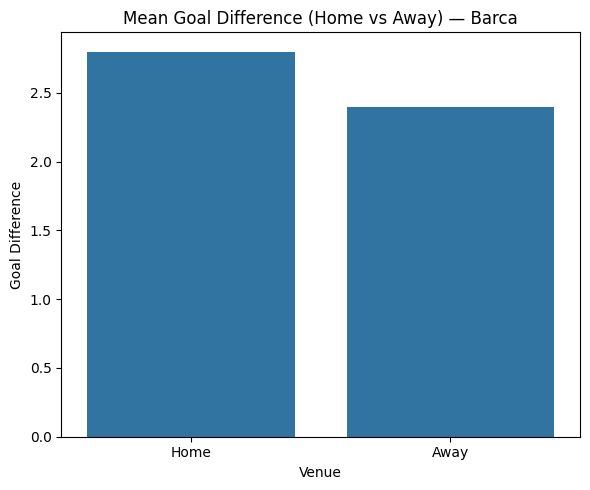

In [22]:
# ----------------------
# Task 1: favorite team home vs away
# ----------------------
teams = sorted(long["team"].unique().tolist())
FAV_TEAM = teams[0]  # change here if you want a different default
fav_data = long[long["team"] == FAV_TEAM]

print(f"\n[Task 1] Favorite team: {FAV_TEAM}")
print("Home mean GD:", round(fav_home.mean(), 3), "| Away mean GD:", round(fav_away.mean(), 3))
print("Home median GD:", round(fav_home.median(), 3), "| Away median GD:", round(fav_away.median(), 3))

plt.figure(figsize=(6,5))
sns.barplot(data=fav_data, x="venue", y="goal_diff", estimator=np.mean, errorbar=('ci', False))
plt.title(f"Mean Goal Difference (Home vs Away) — {FAV_TEAM}")
plt.ylabel("Goal Difference")
plt.xlabel("Venue")
plt.tight_layout()
plt.show()

<div style="border: 2px solid #8ad3f1; border-radius: 10px; padding: 15px; background-color: #f0f8ff;" dir="rtl">

# שאלה 2

</div>

##### 2. (4%) Identify the team with the highest 75th percentile performance in away games. For each team, calculate the goal difference for all away matches (goals scored minus goals against) and determine the 75th value. Which team comes out on top?

In [28]:
# ----------------------
# Task 2: 75th percentile of away GD per team
# ----------------------
# חישוב goal difference של משחקי חוץ
away_gd = (df["away_score"] - df["home_score"]).astype(float)

# טבלה עם קבוצת חוץ וההפרש שלה
away_df = pd.DataFrame({
    "away_team": df["away_team"],
    "away_gd": away_gd
})

# חישוב אחוזון 75 לכל קבוצה
q75_per_team = (
    away_df
    .groupby("away_team")["away_gd"]
    .quantile(0.75)
    .sort_values(ascending=False)
)

# הצגת התוצאות
print("\n75th percentile of away GD per team:\n")
print(q75_per_team)

# זיהוי הקבוצה המובילה
top_team = q75_per_team.idxmax()
top_val = q75_per_team.max()
print(f"\n[Task 2] Top team: {top_team} | value = {top_val:.2f}")


75th percentile of away GD per team:

away_team
Barca        4.75
Real         4.50
ManC         2.75
PSG          1.00
Liverpool    0.00
Inter       -1.75
Name: away_gd, dtype: float64

[Task 2] Top team: Barca | value = 4.75


<div style="border: 2px solid #8ad3f1; border-radius: 10px; padding: 15px; background-color: #f0f8ff;" dir="rtl">

# שאלה 3

</div>

##### 3. (4%) Create a bar chart showing the goal difference for each team (i.e., total goals scored minus total goals against). Based on this plot, which team appears to be the strongest, and which one the weakest?




Total Goal Difference (GD) per team (descending):

           total_GD
team               
Real           57.0
Barca          52.0
ManC           40.0
PSG             1.0
Liverpool     -31.0
Inter        -119.0

[Task 3] Strongest: Real | GD = 57
[Task 3] Weakest:  Inter  | GD = -119


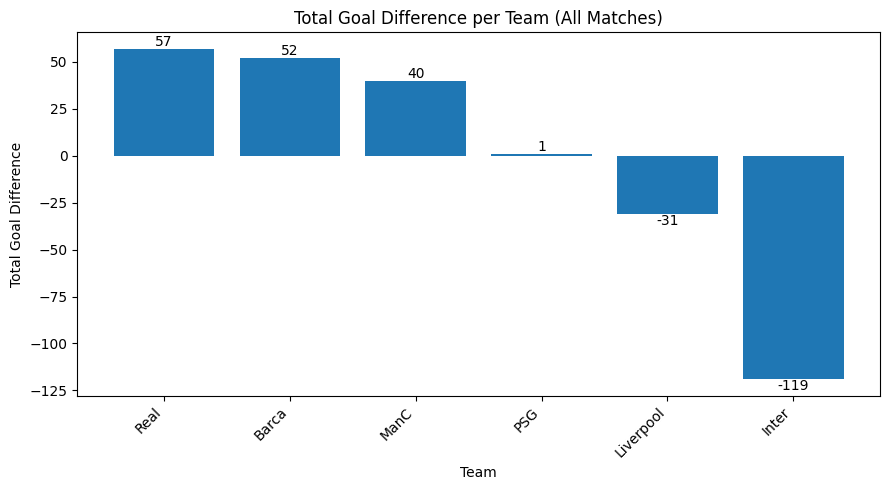

In [30]:
# ----------------------
# Task 3: total GD per team
# ----------------------
gd_per_team = (
    long.groupby("team")["goal_diff"]
        .sum()
        .sort_values(ascending=False)
)

print("\nTotal Goal Difference (GD) per team (descending):\n")
print(gd_per_team.to_frame("total_GD").to_string())

# זיהוי החזקה והחלשה
strongest = gd_per_team.index[0]
weakest = gd_per_team.index[-1]
print(f"\n[Task 3] Strongest: {strongest} | GD = {int(gd_per_team.iloc[0])}")
print(f"[Task 3] Weakest:  {weakest}  | GD = {int(gd_per_team.iloc[-1])}")

# plot 
plt.figure(figsize=(9,5))
plt.bar(gd_per_team.index.astype(str), gd_per_team.values)
for i, v in enumerate(gd_per_team.values):
    plt.text(i, v + (0.02 if v>=0 else -0.02), f"{v:.0f}",
             ha="center", va="bottom" if v>=0 else "top")
plt.title("Total Goal Difference per Team (All Matches)")
plt.ylabel("Total Goal Difference")
plt.xlabel("Team")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

<div style="border: 2px solid #8ad3f1; border-radius: 10px; padding: 15px; background-color: #f0f8ff;" dir="rtl">

# שאלה 4

</div>

##### 4. (4%) Generate the same bar chart over time for each team. Do any teams exhibit a clear trend, either improving or declining in performance?

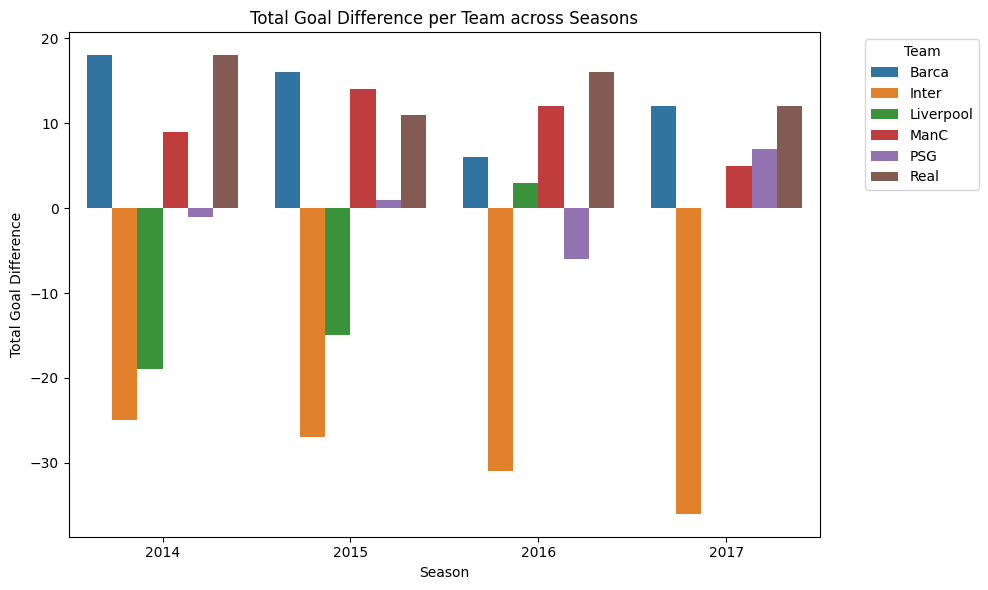

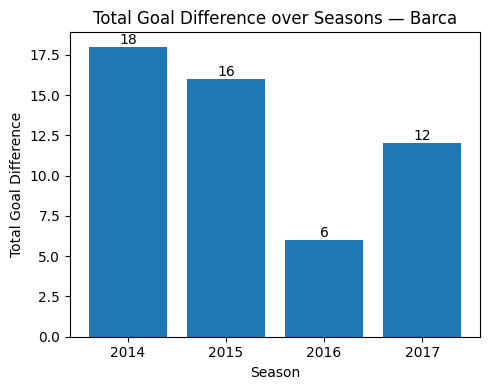

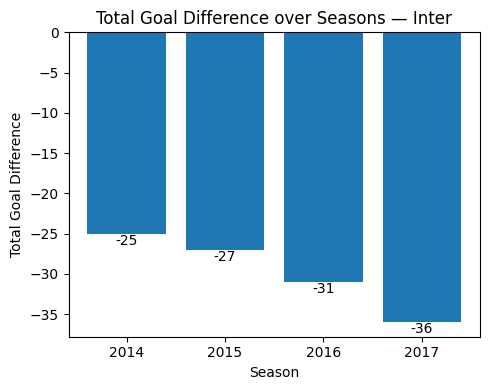

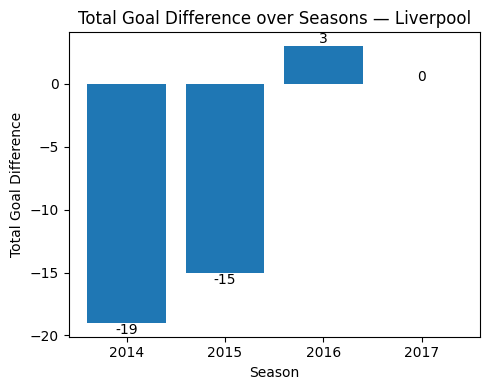

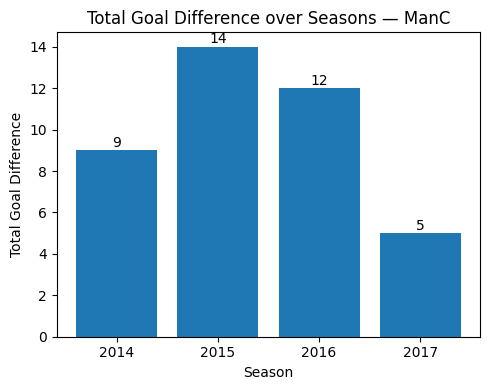

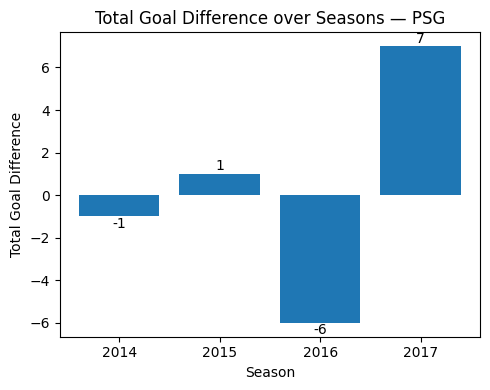

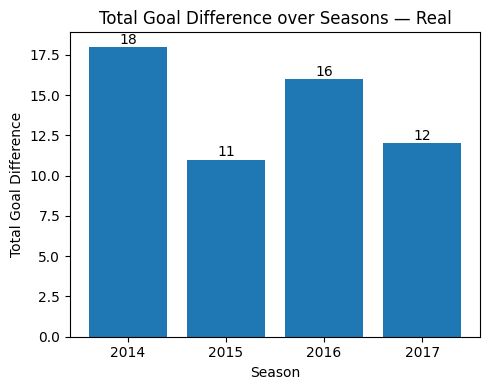

Trend slope per team (no column renaming),
         team  slope
0  Liverpool    7.5
1        PSG    1.7
2       Real   -1.3
3       ManC   -1.4
4      Barca   -2.8
5      Inter   -3.7
[Task 4] Most improving: Liverpool | slope = 7.5
[Task 4] Most declining: Inter | slope = -3.7


C:\Users\razel\AppData\Local\Temp\ipykernel_7096\4075109380.py:42: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: np.polyfit(g["_season_num"], g["goal_diff"], 1)[0])


In [37]:
# ----------------------
# Task 4: total GD per team over seasons + trends
# ----------------------
gd_team_season = (long.groupby(["team", "season"])["goal_diff"]
                  .sum().reset_index())

# חישוב סה"כ goal_diff לכל קבוצה בכל עונה
gd_team_season = (
    long.groupby(["season", "team"])["goal_diff"]
        .sum()
        .reset_index()
)

# ---- גרף מאוחד ----
plt.figure(figsize=(10,6))
sns.barplot(data=gd_team_season, x="season", y="goal_diff", hue="team")
plt.title("Total Goal Difference per Team across Seasons")
plt.ylabel("Total Goal Difference")
plt.xlabel("Season")
plt.legend(title="Team", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

for t in sorted(gd_team_season["team"].unique()):
    df_t = gd_team_season[gd_team_season["team"] == t].sort_values("season")
    plt.figure(figsize=(5,4))
    plt.bar(df_t["season"].astype(str), df_t["goal_diff"].values)
    for i, v in enumerate(df_t["goal_diff"].values):
        plt.text(i, v + (0.02 if v>=0 else -0.02), f"{v:.0f}", ha="center", va="bottom" if v>=0 else "top")
    plt.title(f"Total Goal Difference over Seasons — {t}")
    plt.ylabel("Total Goal Difference")
    plt.xlabel("Season")
    plt.tight_layout()
    plt.show()

# trend slopes
seasons_sorted = sorted(df["year"].unique().tolist())
season_to_num = {s:i for i,s in enumerate(seasons_sorted)}
gd_team_season["_season_num"] = gd_team_season["season"].map(season_to_num)

slopes = (gd_team_season.groupby("team")
          .apply(lambda g: np.polyfit(g["_season_num"], g["goal_diff"], 1)[0])
          .sort_values(ascending=False)
          .rename("slope"))
print(f"Trend slope per team (no column renaming),\n {slopes.to_frame().reset_index()}")
print(f"[Task 4] Most improving:", slopes.idxmax(), "| slope =", round(slopes.max(), 3))
print(f"[Task 4] Most declining:", slopes.idxmin(), "| slope =", round(slopes.min(), 3))

<div style="border: 2px solid #8ad3f1; border-radius: 10px; padding: 15px; background-color: #f0f8ff;" dir="rtl">

## שאלה 4 – ניתוח הפרש שערים לאורך עונות

<div dir="rtl"

1. יצרנו טבלה ארוכה (`long`) שבה לכל קבוצה יש חישוב של `goal_diff` בכל משחק.  
2. חישבנו לכל קבוצה את סך ה־`goal_diff` בכל עונה בעזרת `groupby(["team","season"]).sum()`.  
3. יצרנו שני סוגי גרפים:
   - **גרף מאוחד** שבו מוצגים כל הקבוצות לכל עונה (מאפשר לזהות מגמות השוואתיות בעין).  
   - **גרף אישי לכל קבוצה** שמראה את השינוי לאורך 4 העונות.  
4. כדי למדוד מגמות כמותיות חישבנו שיפוע לינארי (`np.polyfit`) של `goal_diff` כפונקציה של השנה לכל קבוצה.  
   - שיפוע חיובי → מגמת שיפור.  
   - שיפוע שלילי → מגמת ירידה.

### מה רואים בגרפים?

<div dir="rtl"

- **Liverpool**: התחילה חלש מאוד (הפרש שלילי) אך השתפרה בצורה הדרגתית עד קרוב לאיזון → מגמת שיפור ברורה.  
- **Inter**: נשארת שלילית לאורך כל העונות ואף מדרדרת יותר ויותר → מגמת ירידה מובהקת.  
- **PSG**: תנודתיות – ירידה ב־2016 ואח״כ קפיצה חזקה ב־2017 → שיפור מתון בסך הכול (שיפוע חיובי).  
- **Real** ו־**Barca**: התחילו גבוה מאוד ב־2014, אך בהמשך ירדו מעט ברמה → שיפוע שלילי (היחלשות קלה).  
- **ManC**: שיא ב־2015, אך ירידה לאחר מכן → גם כאן שיפוע שלילי.  

### תוצאות חישוב השיפועים

<div dir="rtl"

- **הכי משתפרת**: Liverpool (שיפוע ≈ +7.5)  
- **הכי מדרדרת**: Inter (שיפוע ≈ −3.7)  

---
<div dir="rtl"

📊 לסיכום: הקוד והגרפים מראים באופן ברור שליברפול היא הקבוצה עם המגמת השיפור החזקה ביותר, בעוד אינטר היא הקבוצה החלשה ביותר במונחי מגמה לאורך התקופה.


## Part 2

## What assumptions do we know for our football competition?

### We know that there are 6 teams, each year all possible pairs playes once.  
### We have data from the last few years
### We also know that in sports scoring is modelled as a Poisson distribution.
### We consider home advantage to be a strong effect in sports

# Poisson regression


    
###   Poisson random variable measures the number of events for a single time unit
    
$$ Y\sim Pois(\lambda) $$
    
$$ P(Y=y) = \frac{e^{-\lambda}\lambda^y}{y!} $$
    
$$ E[Y] = V[Y] =\lambda $$
    

    
##  Poisson regression model looks like this:

## $$ (1) \quad  E[Y_i] = \lambda_i = e^{b_0 + b_1 X_{i,1} + b_2 X_{i,2}+...+ b_n X_{i,n}} $$
    
## $$  (2)  \quad  Log(E[Y_i]) = Log(\lambda_i) = b_0 + b_1 X_{i,1} + b_2 X_{i,2}+...+ b_n X_{i,n} $$
    
## $$ (3) \quad  Y_i ~\sim Pois(\lambda_i) $$
    
## i: the index of the instance we wish to infer
## $Y_i$: the value we wish to predict. (כמה גולים קבוצה מסוימת כבשה)
## $\lambda_i$: the expect value we wish to predict. (בעצם הקצב הממוצע - ואיי הוא ערך מהתפלגות פואסונית עם למבדה איי)
## $X_{i,j}$ the value of $i^{th}$ instace and the $j^{th}$ feature. (נראה בהמשך)
## $b_j$ is the parameter of the  $j^{th}$ feature. (מקדמים)


## The model.

### The league is made up by a total of six teams, playing each other once in a season.

### The number of goals scored by the home and the away teams in the g-th game of the season (15 games) are notated by $y_{g_1}$ and $y_{g_2}$ respectively. </p>

### מעניין אותי לדעת כמה גולים היו לכל קבוצה בכל משחק

### The vector of observed goal counts $\mathbb{y} = (y_{g_1}, y_{g_2})$ is modelled as independent Poisson:
## $$y_{g_j}| \delta{g_j} \tilde\;\;  Poisson(\delta{g_j})$$
$$g_j ,  j = 1 (home) , j = 2 (away) $$
### בהינתן איזשהו דלתא הוא מפולג פואסון : למשל כמות הגולים שהקבוצה המאחרת עושים הוא מופלג פואסון 

### where the $\delta$ parameters represent the scoring intensity in the g-th game for the team playing at home (j=1) and away (j=2), respectively.</p>

## We model these parameters according to a formulation that has been used widely in the statistical literature, assuming a log-linear random effect model:
### $$ log \delta_{g_1} = intercept + home + \hat{att}_{h(g)} + \hat{def}_{a(g)} $$
### $$ log \delta_{g_2} = intercept + \hat{att}_{a(g)} + \hat{def}_{h(g)}$$


## Alternatively:

### $$  \delta_{g_1} = e^{ home + \hat{att}_{h(g)} + \hat{def}_{a(g)}} $$
### $$  \delta_{g_2} = e^{\hat{att}_{a(g)} + \hat{def}_{h(g)}}$$

### $\hat{att}_{h(g)}$ is the attack effect of a team.
### $\hat{def}_{h(g)}$ is the attack effect of a team.

### For team  i = 1, ..., 6, both  $\hat{att}_{i}$ and $\hat{def}_{i}$ are normalized values, fomrally:

### $$ \hat{att}_{i} = att_i - \bar{att} $$
### $$ \hat{def}_{i} = def_i - \bar{def} $$

where,

### $$ \bar{att}  = \frac{\sum_{i=1}^6 att_i}{6} $$
### $$ \bar{def}  = \frac{\sum_{i=1}^6 def_i}{6} $$

### Just for clarification: suppose we index teams as follows:
### 1: Real Madrid
### 2: Barcelona
### 3: Liverpool
### 4: Manchester City
### 5: PSG
### 6: Inter

### Now, suppose the first game is Real Madrid hosting Barcelona.
### Thus, $h(1) = 1 $ (i.e.,Real Madrid ) and $a(1) = 2 $ (i.e., Barcelona).

### The parameter home represents the advantage for the team hosting the game and we assume that this effect is constant for all the teams and throughout the season
### The scoring intensity is determined jointly by the attack and defense ability of the two teams involved, represented by the parameters att and def, respectively

### Conversely, for each i = 1, ..., 6, the player-specific effects are modelled as exchangeable from a common distribution:

### $att_{i} \; \tilde\;\; Normal(0,\tau_{att})$ and $def_{i} \; \tilde\;\;Normal(0,\tau_{def})$

### The log function to away scores and home scores is a standard trick in the sports analytics literature

## Tasks

### 1. (10%) Build a Hierarchical model with PyMc where you obtain a posterior of the latent variables: $home$, $att_i$,  and $def_i$ for $i = \{1,2,3,4,5,6\} $.
### Remark: Set the MCMC configuration regarding the number of draws, such that there will 4000 samples in total.



## guidence:
###  For the Hierarchical model, connect the different teams only via the attack and defence std (i.e., $\tau_{att}$ and $\tau_{def}$) and not the mean value.

## Indexing the data for the pymc model

In [3]:
df.head()

,home_team,away_team,home_score,away_score,year
0,ManC,Inter,4,3,2014
1,PSG,Real,5,6,2014
2,Barca,Liverpool,5,1,2014
3,Barca,ManC,5,0,2014
4,Liverpool,Real,0,5,2014


In [4]:
## for your convinience we have here the home and away index with respect to df_all.
home_idx, teams = pd.factorize(df["home_team"], sort=True)
away_idx, _ = pd.factorize(df["away_team"], sort=True)


In [5]:
df.head()

,home_team,away_team,home_score,away_score,year
0,ManC,Inter,4,3,2014
1,PSG,Real,5,6,2014
2,Barca,Liverpool,5,1,2014
3,Barca,ManC,5,0,2014
4,Liverpool,Real,0,5,2014


In [6]:
home_idx

array([3, 4, 0, 0, 2, 4, 3, 1, 5, 0, 2, 5, 1, 3, 4, 3, 1, 4, 5, 0, 2, 2,
       4, 0, 3, 5, 1, 1, 2, 5, 4, 2, 0, 4, 3, 1, 3, 1, 5, 0, 5, 2, 3, 0,
       4, 2, 5, 1, 1, 3, 4, 2, 0, 5, 3, 1, 5, 2, 4, 0])

In [7]:
coords = {"team": teams, 'home_idx': home_idx, 'away_idx': away_idx}

with pm.Model(coords=coords) as football_model:

     # ---------- Hyperpriors (pooling via std only) ----------
    tau_att = pm.HalfNormal("tau_att", sigma=2) # std of attack effects
    tau_def = pm.HalfNormal("tau_def", sigma=2) # std of defense effects

    # ---------- Priors ----------
    home = pm.Normal("home", mu=0, sigma=1)
    att  = pm.Normal("att", mu=0, sigma=tau_att, dims="team")
    def_ = pm.Normal("def", mu=0, sigma=tau_def, dims="team")

    # Centered data  
    att_centered = att - pm.math.mean(att)
    def_centered = def_ - pm.math.mean(def_)

    # Linear predictors for log rates
    home_score_lin = home + att_centered[home_idx] + def_centered[away_idx]
    away_score_lin = att_centered[away_idx] + def_centered[home_idx]

    # Exp Rate models
    delta_g1 = pm.math.exp(home + att_centered[home_idx] + def_centered[away_idx])
    delta_g2 = pm.math.exp(att_centered[away_idx] + def_centered[home_idx])
    
    # Data likelihood for home and away
    y1 = pm.Poisson("y1", mu=delta_g1, observed=df["home_score"])
    y2 = pm.Poisson("y2", mu=delta_g2, observed=df["away_score"])

    trace = pm.sample(draws=2000, tune=1000, chains=2, target_accept=0.9, random_seed=42)


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau_att, tau_def, home, att, def]


Output()

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 904 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


## Part 3

## We aim to understand the different distributions of attacking strength and defensive strength.
## These are probabilistic estimates and help us better understand the uncertainty in sports analytics.

## Tasks

### 1. (5%) Plot the attack and defence strenght HDI for each team and compare them. There should be two graphs, one with the attack HDI of all teams and the other with the defence HDI of all teams.  Which team has the best offence and which has the best defence? who has the worst offence and defence? Does these results is aligned with part 1 analysis?

### 2. (5%) Suppose Inter is hosting PSG for a game. What is the probability that PSG will score more than 3 goals?

### 3. (5%) What is the probability that Liverpool will host Barceolna and win by exactly 2 goals?

### 4. (5%) Simulate who wins over a total of 4000 simulations, one per sample in the posterior. Hint: use the sample_posterior_predictive function.
### The resulting simulation should give you the score per each game for all possible combinations for 4 seasons. For each sample out of the 4000 we can measure who will be ranked 1st, 2nd, etc. The ranking is done as follows:
### If a team wins he gets 3 points, draw a single point and lost 0 points. Sum up the points and you will get a full ranking. If we aggregate the results, we can the probability for each team for each position.

### You are required to draw a bar chart that indicates the probability of all possible ranks for each team.

<div style="border: 2px solid #8ad3f1; border-radius: 10px; padding: 15px; background-color: #f0f8ff;" dir="rtl">

# שאלה 1

</div>

#####  Plot the attack and defence strenght HDI for each team and compare them. There should be two graphs, one with the attack HDI of all teams and the other with the defence HDI of all teams. Which team has the best offence and which has the best defence? who has the worst offence and defence? Does these results is aligned with part 1 analysis?

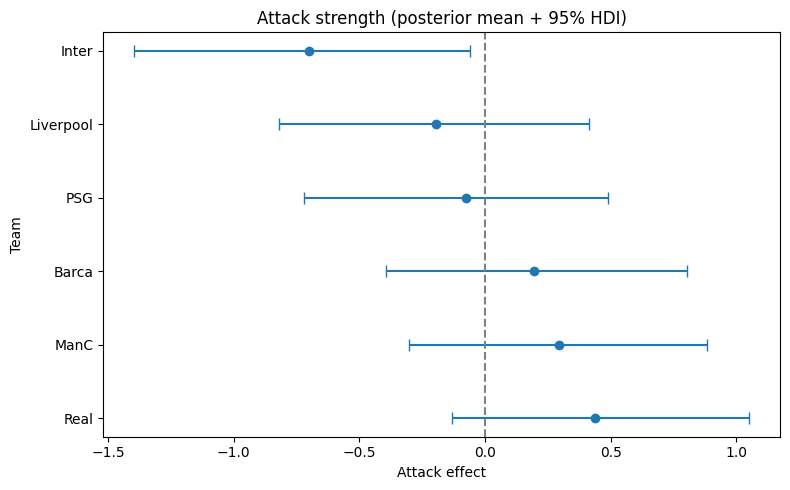

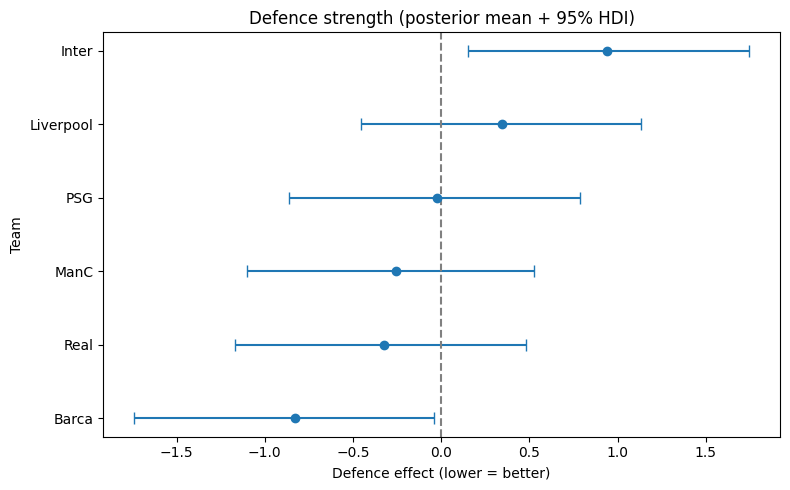

In [24]:
teams = trace.posterior.coords["team"].values

# --- Attack HDI ---
att_da   = trace.posterior["att"]  # dims: (chain, draw, team)
att_mean = att_da.mean(dim=("chain", "draw")).values

att_hdi_da = az.hdi(att_da, hdi_prob=0.95, input_core_dims=[["chain","draw"]])["att"]
att_lower  = att_hdi_da.sel(hdi="lower").values
att_upper  = att_hdi_da.sel(hdi="higher").values

df_att = (pd.DataFrame({
    "team": trace.posterior.coords["team"].values,
    "mean": att_mean,
    "hdi_lower": att_lower,
    "hdi_upper": att_upper
}).sort_values("mean", ascending=False))

x     = df_att["mean"].to_numpy(float)
xlow  = df_att["hdi_lower"].to_numpy(float)
xhigh = df_att["hdi_upper"].to_numpy(float)
xerr  = np.vstack([x - xlow, xhigh - x])

plt.figure(figsize=(8,5))
plt.errorbar(x, df_att["team"], xerr=xerr, fmt="o", capsize=4)
plt.axvline(0, color="grey", linestyle="--")
plt.title("Attack strength (posterior mean + 95% HDI)")
plt.xlabel("Attack effect")
plt.ylabel("Team")
plt.tight_layout()
plt.show()

# --- Defence HDI ---
# --- Defence ---
def_da   = trace.posterior["def"]  # dims: (chain, draw, team)
def_mean = def_da.mean(dim=("chain", "draw")).values

def_hdi_da = az.hdi(def_da, hdi_prob=0.95, input_core_dims=[["chain","draw"]])["def"]
def_lower  = def_hdi_da.sel(hdi="lower").values
def_upper  = def_hdi_da.sel(hdi="higher").values

df_def = (pd.DataFrame({
    "team": trace.posterior.coords["team"].values,
    "mean": def_mean,
    "hdi_lower": def_lower,
    "hdi_upper": def_upper
}).sort_values("mean", ascending=True))  # נמוך = הגנה טובה

x     = df_def["mean"].to_numpy(float)
xlow  = df_def["hdi_lower"].to_numpy(float)
xhigh = df_def["hdi_upper"].to_numpy(float)
xerr  = np.vstack([x - xlow, xhigh - x])

plt.figure(figsize=(8,5))
plt.errorbar(x, df_def["team"], xerr=xerr, fmt="o", capsize=4)
plt.axvline(0, color="grey", linestyle="--")
plt.title("Defence strength (posterior mean + 95% HDI)")
plt.xlabel("Defence effect (lower = better)")
plt.ylabel("Team")
plt.tight_layout()
plt.show()

<div style="border: 2px solid #8ad3f1; border-radius: 10px; padding: 15px; background-color: #f0f8ff;" dir="rtl">
    
## פוסטריורים להתקפה ולהגנה – ממוצע ו־HDI (95%)
### מה עשינו בקוד

<div dir="rtl"

1. לקחנו את הדגימות הפוסטריוריות של אפקטי ההתקפה (`att`) וההגנה (`def`) לכל קבוצה מתוך ה־trace של PyMC.
2. חישבנו לכל קבוצה **ממוצע פוסטריורי** ואת **רווח ה־HDI ברמת 95%** בעזרת.
3. יצרנו שני גרפים:
   - **Attack strength**: נקודת הממוצע לכל קבוצה עם פס ה־HDI.
   - **Defence strength**: אותו רעיון, **כאשר ערך נמוך יותר (שמאלה) משמעו הגנה טובה יותר**.
4. כל האפקטים ממורכזים (sum-to-zero), לכן האפס מייצג “ממוצע ליגה”; ערכים חיוביים/שליליים הם סטיות יחסיות ממנו.

### פרשנות מהגרפים
- **התקפה (Attack)**: נקודה ימינה מ־0 + HDI שרובו מעל 0 → התקפה חזקה מהממוצע.  
  נקודה שמאלה מ־0 + HDI מתחת ל־0 → התקפה חלשה.
- **הגנה (Defence)**: **נמוך יותר = עדיף** (סופגים פחות).  
  נקודה שמאלה מ־0 + HDI מתחת ל־0 → הגנה חזקה. נקודה ימינה/מעל 0 → הגנה חלשה.

### מסקנות מהגרפים
- **התקפה הטובה ביותר**: **Real** – ממוצע התקפי הגבוה ביותר ו־HDI שרובו מעל 0.  
  אחריה: **ManC**, ואז **Barca**.  
  **התקפה חלשה ביותר**: **Inter** – ממוצע שלילי משמעותי (HDI שלילי).
- **הגנה הטובה ביותר**: **Barca** – ממוצע הגנתי הנמוך ביותר (שמאלה), HDI שלילי.  
  גם **Real** ו־**ManC** מציגות הגנה טובה (ערכים שליליים).  
  **הגנה חלשה ביותר**: **Inter** – ממוצע חיובי גבוה (ימינה), HDI מעל 0.  
  **Liverpool** מעט ימינה מאפס (הגנה חלשה מהממוצע), **PSG** קרובה לאפס (ניטרלית בערך).

### האם זה מתיישב עם ניתוח הנתונים מחלק 1?

<div dir="rtl"

כן.  
- ב־EDA ראינו ש־**Real** ו־**Barca** בין החזקות (הפרשי שערים גבוהים), ו־**Inter** החלשה ביותר.  
- כאן: **Real** מובילה בהתקפה, **Barca** מובילה בהגנה, ו־**Inter** חלשה גם בהתקפה וגם בהגנה – תואם לממצאי חלק 1.  
- **ManC** נראית חזקה יחסית בשני הצדדים (בעיקר בהתקפה), **PSG** סביב הממוצע, ו־**Liverpool** עם התקפה מעט מתחת לממוצע והגנה חלשה יחסית – גם זה עולה בקנה אחד עם התמונה הכוללת מ־Part 1.


<div style="border: 2px solid #8ad3f1; border-radius: 10px; padding: 15px; background-color: #f0f8ff;" dir="rtl">

# שאלה 2

</div>

##### Suppose Inter is hosting PSG for a game. What is the probability that PSG will score more than 3 goals?

In [27]:
def prob_away_gt_k(trace, home_team, away_team, k=3, hdi_prob=0.95):
    # פוסטריורים של att/def במידות: (chain, draw, team[labels])
    att_da = trace.posterior["att"]
    def_da = trace.posterior["def"]

    # מרכוז לכל דגימה (כי במודל דגמנו att/def לא ממורכזים ושמנו centering בלייקליודהוד)
    att_c = att_da - att_da.mean(dim="team")
    def_c = def_da - def_da.mean(dim="team")

    # לוג-קצב לשערי חוץ (לפי המפרט שלך: בלי intercept ובלי home אפקט לחוץ)
    eta_away = att_c.sel(team=away_team) + def_c.sel(team=home_team)   # בחירה לפי label!
    lam = np.exp(eta_away).stack(sample=("chain", "draw")).values      # (n_samples,)

    # P(Y > k) עבור פואסון עם λ
    try:
        from scipy.stats import poisson
        p = poisson.sf(k, lam)  # survival function
    except Exception:
        s = np.ones_like(lam)
        term = np.ones_like(lam)
        for j in range(1, k+1):
            term *= lam / j
            s += term
        p = 1.0 - np.exp(-lam) * s

    p_mean = float(p.mean())
    hdi = az.hdi(p, hdi_prob=hdi_prob)  # [lower, upper]
    return p_mean, hdi

# דוגמה לשימוש:
p_mean, p_hdi = prob_away_gt_k(trace, home_team="Inter", away_team="PSG", k=3, hdi_prob=0.95)
print(f"P(PSG scores > 3 @ Inter) = {p_mean:.3f}")
print(f"95% HDI: [{p_hdi[0]:.3f}, {p_hdi[1]:.3f}]")


P(PSG scores > 3 @ Inter) = 0.241
95% HDI: [0.108, 0.410]


<div style="border: 2px solid #8ad3f1; border-radius: 10px; padding: 15px; background-color: #f0f8ff;" dir="rtl">

# שאלה 3

</div>

##### What is the probability that Liverpool will host Barceolna and win by exactly 2 goals?

In [28]:
def prob_home_win_by_margin(trace, home_team, away_team, margin=2, hdi_prob=0.95):
    # פוסטריורים: (chain, draw, team[label])
    att_da = trace.posterior["att"]
    def_da = trace.posterior["def"]
    home_da = trace.posterior["home"]  # יתרון ביתי (scalar per draw/chain)

    # מרכוז בתוך כל דגימה (sum-to-zero)
    att_c = att_da - att_da.mean(dim="team")
    def_c = def_da - def_da.mean(dim="team")

    # לוג-קצבים למשחק המבוקש
    eta_home = home_da + att_c.sel(team=home_team) + def_c.sel(team=away_team)
    eta_away =            att_c.sel(team=away_team) + def_c.sel(team=home_team)
    lam_home = np.exp(eta_home).stack(sample=("chain","draw")).values   # (n_samples,)
    lam_away = np.exp(eta_away).stack(sample=("chain","draw")).values

    # P(D = margin) כאשר D ~ Skellam(lam_home, lam_away)
    try:
        from scipy.stats import skellam
        p = skellam.pmf(margin, lam_home, lam_away)
    except Exception:
        # נפילה חינמית: חישוב ע"י סכום קונבולוציוני (מספיק ל-כדורגל)
        from math import exp, factorial
        K = 15  # חיתוך סביר לכדורגל
        p = []
        for lh, la in zip(lam_home, lam_away):
            s = 0.0
            for k in range(max(0, -margin), K+1):
                # P(Yh=k+margin) * P(Ya=k)
                yh = k + margin
                ph = exp(-lh) * (lh**yh) / factorial(yh)
                pa = exp(-la) * (la**k)  / factorial(k)
                s += ph * pa
            p.append(s)
        p = np.array(p)

    p_mean = float(np.mean(p))
    p_hdi  = az.hdi(p, hdi_prob=hdi_prob)  # [lower, upper]
    return p_mean, p_hdi

p_mean, p_hdi = prob_home_win_by_margin(
    trace, home_team="Liverpool", away_team="Barca", margin=2, hdi_prob=0.95
)
print(f"P(Liverpool hosts Barca and wins by exactly 2) = {p_mean:.3f}")
print(f"95% HDI: [{p_hdi[0]:.3f}, {p_hdi[1]:.3f}]")


P(Liverpool hosts Barca and wins by exactly 2) = 0.075
95% HDI: [0.021, 0.131]


<div style="border: 2px solid #8ad3f1; border-radius: 10px; padding: 15px; background-color: #f0f8ff;" dir="rtl">

# שאלה 4

</div>

##### Simulate who wins over a total of 4000 simulations, one per sample in the posterior. Hint: use the sample_posterior_predictive function.

Sampling: [y1, y2]


Output()

Winner probabilities (per season):
     Barca: 0.468
     Inter: 0.000
 Liverpool: 0.004
      ManC: 0.185
       PSG: 0.037
      Real: 0.306


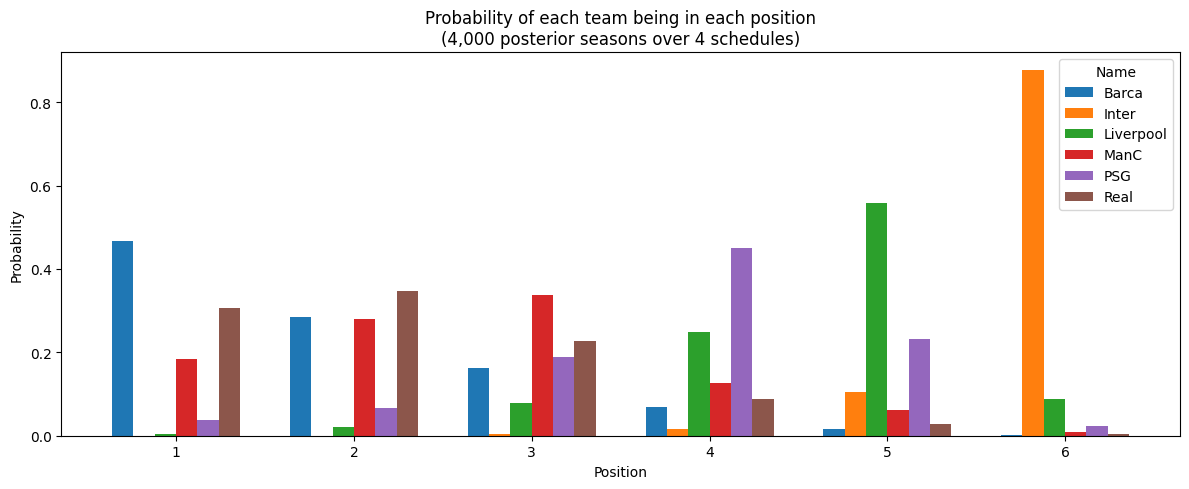

In [31]:
# ==== 0) נתונים בסיסיים ====
years = sorted(df["year"].unique())
teams = trace.posterior.coords["team"].values
N = len(teams)
team_to_idx = {t:i for i,t in enumerate(teams)}

# ==== 1) Predictive posterior sampling (all 60 games) ====
pp = pm.sample_posterior_predictive(
    trace, model=football_model,
    var_names=["y1","y2"], random_seed=123
)

# helper: make sure the sample dimension precedes the observation dimension (sample, obs)
def ppc_to_sample_first(da):
    da_stacked = da.stack(sample=("chain","draw"))
    obs_dim = next(d for d in da_stacked.dims if d != "sample")
    return da_stacked.transpose("sample", obs_dim).values  # (S, n_obs)

y1 = ppc_to_sample_first(pp.posterior_predictive["y1"])  # שערי בית  (S, 60)
y2 = ppc_to_sample_first(pp.posterior_predictive["y2"])  # שערי חוץ  (S, 60)
S, n_obs = y1.shape   # S≈4000, n_obs=60

# ==== 2) Count locations across all samples and all 4 seasons ====
pos_counts = np.zeros((N, N), dtype=int)   # [team_idx, position-1]
winner_counts = np.zeros(N, dtype=int)

for yr in years:
    mask = (df["year"].values == yr)
    idxs = np.where(mask)[0]                 # 15 האינדקסים של העונה
    hteams = df.loc[mask, "home_team"].values
    ateams = df.loc[mask, "away_team"].values

    yh = y1[:, idxs]   # (S, 15)
    ya = y2[:, idxs]   # (S, 15)

    for s in range(S):
        pts = np.zeros(N, dtype=int)
        gf  = np.zeros(N, dtype=int)
        ga  = np.zeros(N, dtype=int)

        for m in range(len(idxs)):
            hs = int(yh[s, m]); as_ = int(ya[s, m])
            hi = team_to_idx[hteams[m]]; ai = team_to_idx[ateams[m]]

            gf[hi] += hs; ga[hi] += as_
            gf[ai] += as_; ga[ai] += hs

            if   hs > as_: pts[hi] += 3
            elif hs < as_: pts[ai] += 3
            else:          pts[hi] += 1; pts[ai] += 1

        tab = (pd.DataFrame({
            "team": teams,
            "points": pts,
            "gd": gf - ga,
            "gf": gf
        })
        .sort_values(["points","gd","gf","team"],
                     ascending=[False,False,False,True])
        .reset_index(drop=True))

        # Update location counts
        for pos, t in enumerate(tab["team"].values, start=1):
            pos_counts[team_to_idx[t], pos-1] += 1
        winner_counts[team_to_idx[tab.loc[0,"team"]]] += 1

# ==== 3) Location probabilities (normalized by #samples × #seasons) ====
denom = S * len(years)
pos_probs = pos_counts / denom           # (N teams × N positions)
win_probs = winner_counts / denom

print("Winner probabilities (per season):")
for i, t in enumerate(teams):
    print(f"{t:>10s}: {win_probs[i]:.3f}")

# ==== 4) Graph: Probability for each location for each group ====
positions = np.arange(1, N+1)
width = 0.12

plt.figure(figsize=(12,5))
for i, t in enumerate(teams):
    shift = (i - (N-1)/2) * width
    plt.bar(positions + shift, pos_probs[i, :], width=width, label=t)
plt.xticks(positions)
plt.xlabel("Position")
plt.ylabel("Probability")
plt.title("Probability of each team being in each position\n(4,000 posterior seasons over 4 schedules)")
plt.legend(title="Name")
plt.tight_layout()
plt.show()
